Total Overlap: 19.079633333332986
Average Density: 0.45772510136109773
Max Density: 0.5648008901802425
Score: 107.76510352897702


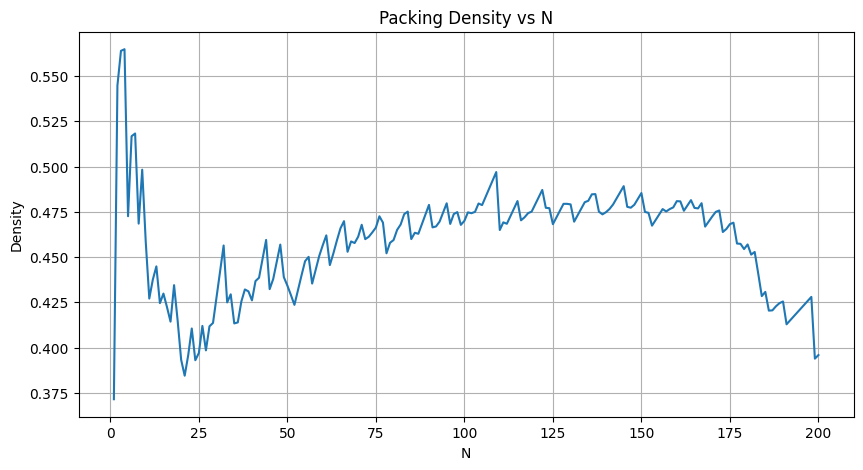

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree definition
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
TREE_COORDS = list(zip(TX, TY))
TREE_POLY = Polygon(TREE_COORDS)
TREE_AREA = TREE_POLY.area

def get_tree(x, y, angle):
    t = affinity.rotate(TREE_POLY, angle, origin=(0,0))
    t = affinity.translate(t, x, y)
    return t

def check_submission(file_path):
    df = pd.read_csv(file_path)
    
    # Parse columns
    # x, y, deg are strings like "s1.23"
    df['x_val'] = df['x'].apply(lambda s: float(s[1:]) if s.startswith('s') else float(s))
    df['y_val'] = df['y'].apply(lambda s: float(s[1:]) if s.startswith('s') else float(s))
    df['deg_val'] = df['deg'].apply(lambda s: float(s[1:]) if s.startswith('s') else float(s))
    
    df['n'] = df['id'].apply(lambda s: int(s.split('_')[0]))
    
    results = []
    
    for n in sorted(df['n'].unique()):
        subset = df[df['n'] == n]
        polys = []
        for _, row in subset.iterrows():
            polys.append(get_tree(row['x_val'], row['y_val'], row['deg_val']))
            
        # Check overlaps
        overlap_area = 0
        for i in range(len(polys)):
            for j in range(i+1, len(polys)):
                if polys[i].intersects(polys[j]):
                    overlap_area += polys[i].intersection(polys[j]).area
        
        # Calculate bounding box
        minx = min(p.bounds[0] for p in polys)
        miny = min(p.bounds[1] for p in polys)
        maxx = max(p.bounds[2] for p in polys)
        maxy = max(p.bounds[3] for p in polys)
        
        side = max(maxx - minx, maxy - miny)
        score = side**2 / n
        density = (n * TREE_AREA) / (side**2)
        
        results.append({
            'n': n,
            'overlap': overlap_area,
            'score': score,
            'density': density
        })
        
    res_df = pd.DataFrame(results)
    return res_df

df_res = check_submission('experiments/002_lattice_init/submission.csv')
print("Total Overlap:", df_res['overlap'].sum())
print("Average Density:", df_res['density'].mean())
print("Max Density:", df_res['density'].max())
print("Score:", df_res['score'].sum())

# Plot density
plt.figure(figsize=(10, 5))
plt.plot(df_res['n'], df_res['density'])
plt.title('Packing Density vs N')
plt.xlabel('N')
plt.ylabel('Density')
plt.grid(True)
plt.savefig('experiments/002_lattice_init/density_plot.png')
